/var/folders/jd/rckqvbxx33q6r_78vmp56qhr0000gn/T/ipykernel_4915/529955509.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


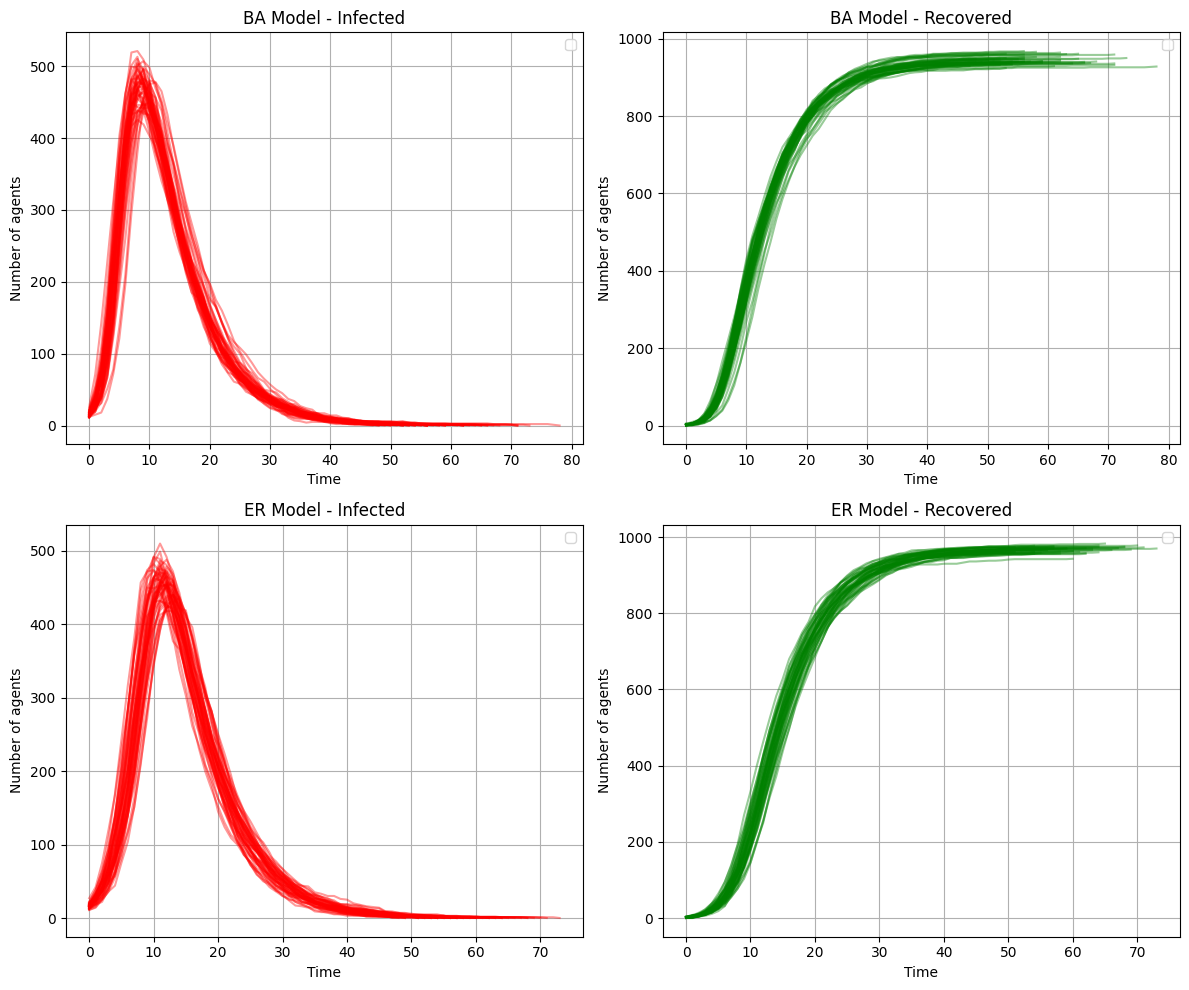

In [1]:
import matplotlib.pyplot as plt
import ModelSIR as ms
import numpy as np
import networkx as nx


# Parameters for BA model
N = 1000
infection_prob = 0.1
recovery_time = 7
m = 4
runs = 50

# Parameters for ER model
N_ER = 1000
infection_prob_ER = 0.1
recovery_time_ER = 7
m_ER = 8
model_ER_type = "ER"

# Colors
recovered_color = 'green'
infected_color = 'red'

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
(ax_ba_I, ax_ba_R), (ax_er_I, ax_er_R) = axes


# Run simulations
for i in range(runs):
    # Barabási-Albert model
    model_ba = ms.ModelSIR(N=N, infection_prob=infection_prob, recovery_time=recovery_time, m=m, model="BA")
    df_ba = model_ba.step()
    ax_ba_I.plot(df_ba["time"], df_ba["I"], alpha=0.4, color=infected_color)
    ax_ba_R.plot(df_ba["time"], df_ba["R"], alpha=0.4, color=recovered_color)

    # Erdős–Rényi model
    model_er = ms.ModelSIR(N=N_ER, infection_prob=infection_prob_ER, recovery_time=recovery_time_ER, m=m_ER, model=model_ER_type)
    df_er = model_er.step()
    ax_er_I.plot(df_er["time"], df_er["I"], alpha=0.4, color=infected_color)
    ax_er_R.plot(df_er["time"], df_er["R"], alpha=0.4, color=recovered_color)

# Titles in English
ax_ba_I.set_title("BA Model - Infected")
ax_ba_R.set_title("BA Model - Recovered")
ax_er_I.set_title("ER Model - Infected")
ax_er_R.set_title("ER Model - Recovered")

# Common labels and styling
for ax in [ax_ba_I, ax_ba_R, ax_er_I, ax_er_R]:
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of agents")
    ax.grid(True)
    ax.legend()

# Layout adjustment
plt.tight_layout()
plt.show()


In [2]:

def compute_attack_rate(model_mmca, attack_rate_values_mmca, lambda_):
    mu = 1 / model_mmca.recovery_time
    
    # Valores iniciales
    infected_probability = len(model_mmca.infected) / model_mmca.num_agents
    rho_S = 1 - infected_probability
    rho_I = infected_probability
    rho_R = 0
    rho = [rho_S, rho_I, rho_R]
    avg_degree = np.mean([len(list(model_mmca.network.neighbors(a.unique_id))) for a in model_mmca.susceptibles])
    
    steps = 0
    while rho[1] > 1e-6 and steps < N:
        rho_old = rho.copy()
        contagion_prob = 1 - (1 - lambda_ * rho_old[1]) ** avg_degree
        rho[0] = rho_old[0] * (1 - contagion_prob)
        rho[1] = (1 - mu) * rho_old[1] + rho_old[0] * contagion_prob
        rho[2] = rho_old[2] + rho_old[1] * mu
        steps += 1

    attack_rate_values_mmca.append(rho[2]) # type: ignore


KeyboardInterrupt: 

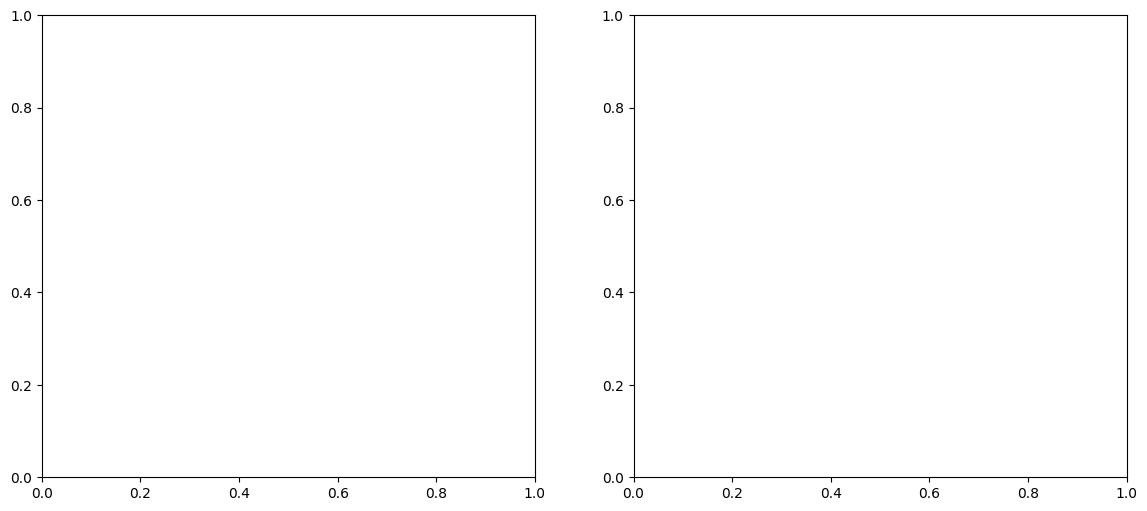

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ModelSIR as ms
import networkx as nx

# Parámetros comunes
N = 1000
infection_prob = 0.1
recovery_time = 7
m = 4
runs = 50

# Parámetros ER
N_ER = 1000
infection_prob_ER = 0.1
recovery_time_ER = 7
m_ER = 8
model_ER_type = "ER"

ratios = np.linspace(0.0, 1.0, 21) 

# Crear figura con 1x2 subplots
fig, (ax_ba, ax_er) = plt.subplots(1, 2, figsize=(14, 6))

# DataFrames para guardar los resultados
df_ro = pd.DataFrame(columns=['realization', 'λ', 'time', 'attack_rate'])
df_ro_er = pd.DataFrame(columns=['realization', 'λ', 'time', 'attack_rate'])

row, row_er = 0, 0

model_mmca_ba = ms.ModelSIR(N, infection_prob, recovery_time, m, model="BA", lam=-1)
A = np.linalg.eigvals(nx.adjacency_matrix(model_mmca_ba.network).todense()).real
mu = 1 / model_mmca_ba.recovery_time
lambda_max_ba = max(A)
lambda_c_ba = mu / lambda_max_ba
    

lambdas_ba = np.linspace(0, 4 * lambda_c_ba, 21)

model_mmca_er = ms.ModelSIR(N_ER, infection_prob_ER, recovery_time_ER, m_ER, model="ER", lam=-1)
B = np.linalg.eigvals(nx.adjacency_matrix(model_mmca_er.network).todense()).real
lambda_c_er = 1 / max(np.linalg.eigvals(nx.adjacency_matrix(model_mmca_ba.network).todense()).real)
lambda_max_er = max(B)
lambda_c_er = mu / lambda_max_er

lambdas_er = np.linspace(0, 4 * lambda_c_er, 21)

# Bucle de simulación
for lambda_ in lambdas_ba:  
    for step in range(runs):
        # --- BA Model ---
        model_ba = ms.ModelSIR(N, infection_prob, recovery_time, m, model="BA", lam=lambda_)
        result_ba = model_ba.step()
        for t in range(len(result_ba)):
            df_ro.loc[row] = [step, lambda_, result_ba.loc[t, 'time'], result_ba.loc[t, 'attack_rate']]
            row += 1

for lambda_ in lambdas_er:  
    for step in range(runs):
        # --- ER Model ---
        model_er = ms.ModelSIR(N_ER, infection_prob_ER, recovery_time_ER, m_ER, model="ER", lam=lambda_)
        result_er = model_er.step()
        for t in range(len(result_er)):
            df_ro_er.loc[row_er] = [step, lambda_, result_er.loc[t, 'time'], result_er.loc[t, 'attack_rate']]
            row_er += 1

# Obtener el último valor de attack_rate por simulación
last_steps_ba = df_ro.groupby(['realization', 'λ']).tail(1)
last_steps_er = df_ro_er.groupby(['realization', 'λ']).tail(1)

# Agrupar para obtener medias y desviaciones
df_grouped_ba = last_steps_ba.groupby('λ')['attack_rate'].agg(['mean', 'std']).reset_index()
df_grouped_er = last_steps_er.groupby('λ')['attack_rate'].agg(['mean', 'std']).reset_index()

# --- Plot BA ---
#ax_ba.plot(ratios, attack_rate_values_MMCA, label='MMCA', color='blue', marker='o')
ax_ba.errorbar(df_grouped_ba['λ'], df_grouped_ba['mean'], yerr=df_grouped_ba['std'], fmt='o', color='blue', label='Simulation')
ax_ba.set_title('BA Model - Attack Rate vs λ', fontsize=14)
ax_ba.set_xlabel('λ', fontsize=12)
ax_ba.set_ylabel('Attack Rate', fontsize=12)
ax_ba.grid(True)
ax_ba.legend()
ax_ba.tick_params(axis='both', labelsize=10)

# --- Plot ER ---
#ax_er.plot(ratios, attack_rate_values_MMCA_er, label='MMCA', color='blue', marker='o')
ax_er.errorbar(df_grouped_er['λ'], df_grouped_er['mean'], yerr=df_grouped_er['std'], fmt='o', color='orange', label='Simulation')
ax_er.set_title('ER Model - Attack Rate vs λ', fontsize=14)
ax_er.set_xlabel('λ', fontsize=12)
ax_er.set_ylabel('Attack Rate', fontsize=12)
ax_er.grid(True)
ax_er.legend()
ax_er.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()


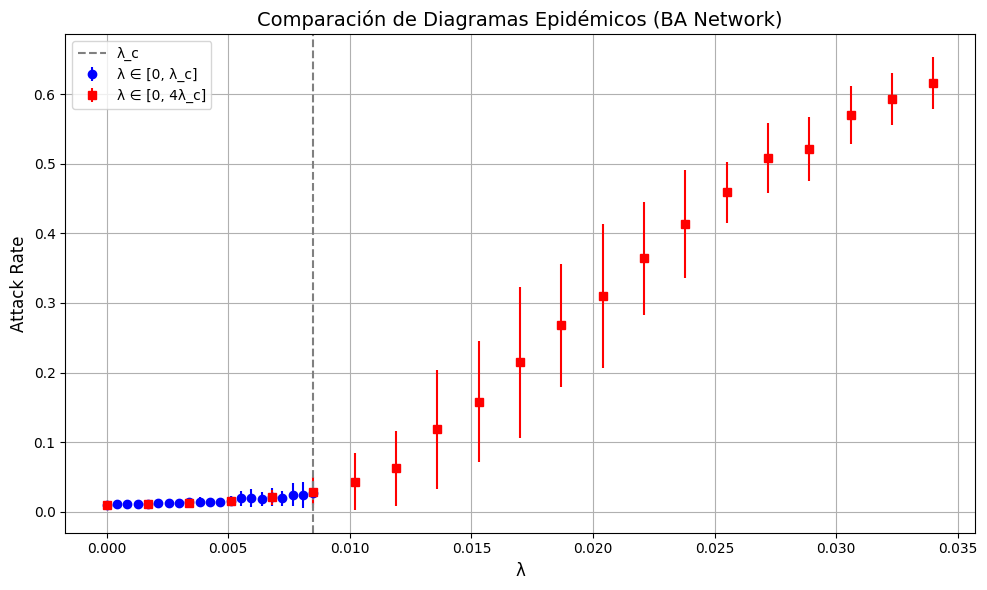

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ModelSIR as ms
import networkx as nx

# --- Parámetros del modelo ---
N = 1000
infection_prob = 0.1
recovery_time = 7
m = 4
mu = 1 / recovery_time
runs = 50

# --- Calcular λ_c ---
temp_model = ms.ModelSIR(N, infection_prob, recovery_time, m, model="BA", lam=-1)
A = nx.adjacency_matrix(temp_model.network).todense()
lambda_max = max(np.linalg.eigvals(A).real)
lambda_c = mu / lambda_max

# --- Rango de λ ---
lambdas_short = np.linspace(0, lambda_c, 21)
lambdas_long = np.linspace(0, 4 * lambda_c, 21)

def simulate_attack_rates(lambdas):
    results = []
    for lam in lambdas:
        rates = []
        for _ in range(runs):
            model = ms.ModelSIR(N, infection_prob, recovery_time, m, model="BA", lam=lam)
            result = model.step()
            attack_rate = result['attack_rate'].iloc[-1]
            rates.append(attack_rate)
        results.append((lam, np.mean(rates), np.std(rates)))
    return pd.DataFrame(results, columns=['λ', 'mean', 'std'])

# --- Simulaciones ---
df_short = simulate_attack_rates(lambdas_short)
df_long = simulate_attack_rates(lambdas_long)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.errorbar(df_short['λ'], df_short['mean'], yerr=df_short['std'], label='λ ∈ [0, λ_c]', fmt='o', color='blue')
plt.errorbar(df_long['λ'], df_long['mean'], yerr=df_long['std'], label='λ ∈ [0, 4λ_c]', fmt='s', color='red')
plt.axvline(lambda_c, color='gray', linestyle='--', label='λ_c')
plt.title('Comparación de Diagramas Epidémicos (BA Network)', fontsize=14)
plt.xlabel('λ', fontsize=12)
plt.ylabel('Attack Rate', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
